In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set(rc={'figure.figsize':(12,8)})
from scipy import stats
import random
from scipy.signal import find_peaks

In [7]:
root_dir = "../Data Bar Crawl/"
list_dir =sorted(os.listdir(root_dir))
list_dir

['README.txt',
 'all_accelerometer_data_pids_13.csv',
 'clean_tac',
 'phone_types.csv',
 'pids.txt',
 'raw_tac']

In [8]:
os.chdir(root_dir)
dataFile = list_dir[1]
data = pd.read_csv(dataFile)
data.head()

,time,pid,x,y,z
0,0,JB3156,0.0000,0.0000,0.0000
1,0,CC6740,0.0000,0.0000,0.0000
2,1493733882409,SA0297,0.0758,0.0273,-0.0102
3,1493733882455,SA0297,-0.0359,0.0794,0.0037
4,1493733882500,SA0297,-0.2427,-0.0861,-0.0163


In [9]:
data.shape

(14057567, 5)

In [10]:
data['time'].dtype

dtype('int64')

## Clean data and drop rows where timestamp is 0 . Order the data in ascending order of user and timestamp

In [11]:
data = data[data['time'] != 0]
data = data.sort_values(by=['pid','time'],ignore_index=True)

In [12]:
data.head()

,time,pid,x,y,z
0,1493735870653,BK7610,0.1261,-0.0078,-0.0243
1,1493735870679,BK7610,0.1336,-0.0697,-0.0446
2,1493735870703,BK7610,0.1443,-0.0474,-0.0447
3,1493735870729,BK7610,0.1255,-0.0038,0.0111
4,1493735870753,BK7610,0.1076,0.0032,0.0276


## Read the TAC readings file

In [14]:
os.chdir(root_dir)
tac_dir = "/clean_tac"
os.chdir(root_dir + tac_dir)
tacLsdir = os.listdir()
tacs = {}
for pid_csv in tacLsdir:
    pid = pid_csv[:6]
    # print(pid)
    tacs[pid] = pd.read_csv(pid_csv)

BK7610
BU4707
CC6740
DC6359
DK3500
HV0618
JB3156
JR8022
MC7070
MJ8002
PC6771
SA0297
SF3079


In [15]:
# tacs
pid_acc_data={}
pids = list(tacs.keys())
for pid in pids:
    pid_acc_data[pid] = data[data['pid']==pid]

In [16]:
pid_acc_data['BK7610']

,time,pid,x,y,z
0,1493735870653,BK7610,0.1261,-0.0078,-0.0243
1,1493735870679,BK7610,0.1336,-0.0697,-0.0446
2,1493735870703,BK7610,0.1443,-0.0474,-0.0447
3,1493735870729,BK7610,0.1255,-0.0038,0.0111
4,1493735870753,BK7610,0.1076,0.0032,0.0276
...,...,...,...,...,...
1225722,1493767770540,BK7610,-0.0784,-0.0161,0.1719
1225723,1493767770564,BK7610,-0.0395,-0.0816,0.1634
1225724,1493767770590,BK7610,0.0160,-0.0853,0.0906
1225725,1493767770614,BK7610,0.0901,-0.0767,0.0162


In [17]:
all_data = []
for pid in pids:
    df1 = tacs[pid]
#     Shift TAC reading by 45 minutes before merging with accelerometer data
    # df1['shift_timestamp'] = df1['timestamp'] - (45*60)
    df2 = data[data['pid']==pid]
#     Change timestamp in accelerometer data from milisec to sec
    df2['timestamp'] = df2['time']//1000 
#     Merge the TAC reading and accelerometer data on timestamp
    tmp = df1.merge(df2, on= 'timestamp')
    tmp['label'] = np.where(tmp['TAC_Reading']<0.08, 0, 1)

    all_data.append(tmp)
large_df = pd.concat(all_data)

<ipython-input-17-743ea1c55821>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['timestamp'] = df2['time']//1000


In [18]:
large_df.head()

,timestamp,TAC_Reading,time,pid,x,y,z,label
0,1493737046,0.065357,1493737046023,BK7610,0.1410,-0.2686,-0.1372,0
1,1493737046,0.065357,1493737046063,BK7610,0.1714,-0.2722,-0.1208,0
2,1493737046,0.065357,1493737046073,BK7610,0.3328,-0.1353,-0.2548,0
3,1493737046,0.065357,1493737046101,BK7610,0.2822,-0.0375,-0.2816,0
4,1493737046,0.065357,1493737046134,BK7610,0.1847,0.1813,-0.2680,0


<ipython-input-24-170ba00cb360>:3: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[0].plot("timestamp","x",data=large_df[large_df['pid']=="BK7610"])
<ipython-input-24-170ba00cb360>:4: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[1].plot("timestamp","y",data=large_df[large_df['pid']=="BK7610"])


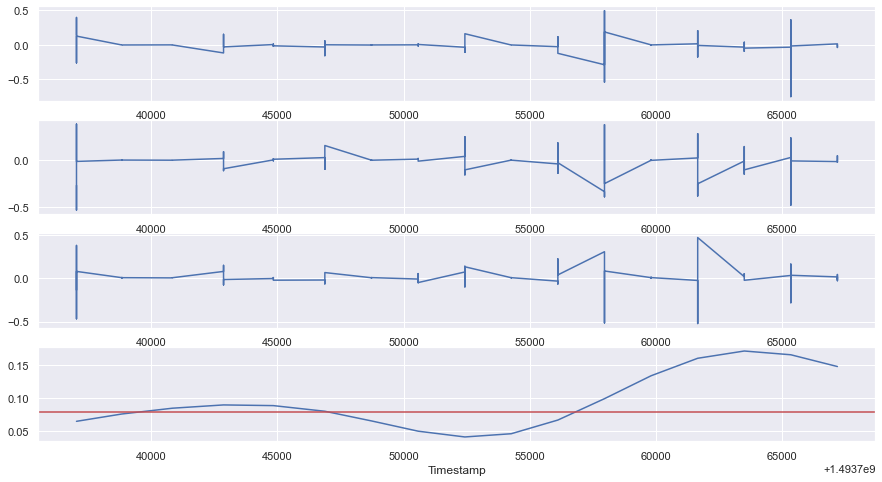

In [24]:
fig, ax = plt.subplots(4,figsize=(15,8))
plt.xlabel("Timestamp")
ax[0].plot("timestamp","x",data=large_df[large_df['pid']=="BK7610"])
ax[1].plot("timestamp","y",data=large_df[large_df['pid']=="BK7610"])
ax[2].plot("timestamp","z",data=large_df[large_df['pid']=="BK7610"])
ax[3].plot("timestamp",'TAC_Reading', data=large_df[large_df['pid']=="BK7610"])
ax[3].axhline(y=0.08, color='r', linestyle='-')
plt.show()

In [25]:
large_df.timestamp.dtype

dtype('int64')

##  Sampling for 800 rows -> 20 seconds of timestamp 

<ipython-input-31-cb14841ac0ac>:5: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[0].plot("timestamp","x",data=zoomed)
<ipython-input-31-cb14841ac0ac>:6: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[1].plot("timestamp","y",data=zoomed)


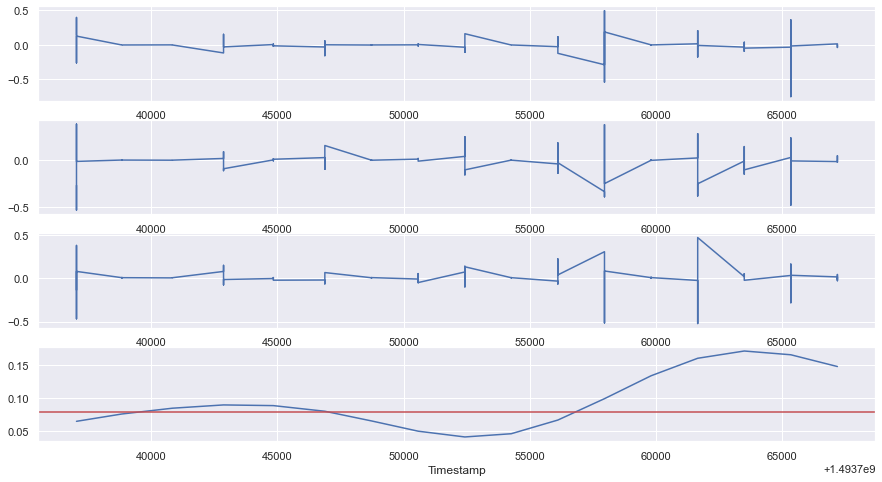

In [31]:
BK7 = large_df[large_df['pid']=="BK7610"]
zoomed = BK7[:800]
fig, ax = plt.subplots(4,figsize=(15,8))
plt.xlabel("Timestamp")
ax[0].plot("timestamp","x",data=zoomed)
ax[1].plot("timestamp","y",data=zoomed)
ax[2].plot("timestamp","z",data=zoomed)
ax[3].plot("timestamp",'TAC_Reading', data=zoomed)
ax[3].axhline(y=0.08, color='r', linestyle='-')
plt.show()

<ipython-input-35-748d1573cfc3>:7: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[0].plot(time,"x",data=zoomed)
<ipython-input-35-748d1573cfc3>:8: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[1].plot(time,"y",data=zoomed)


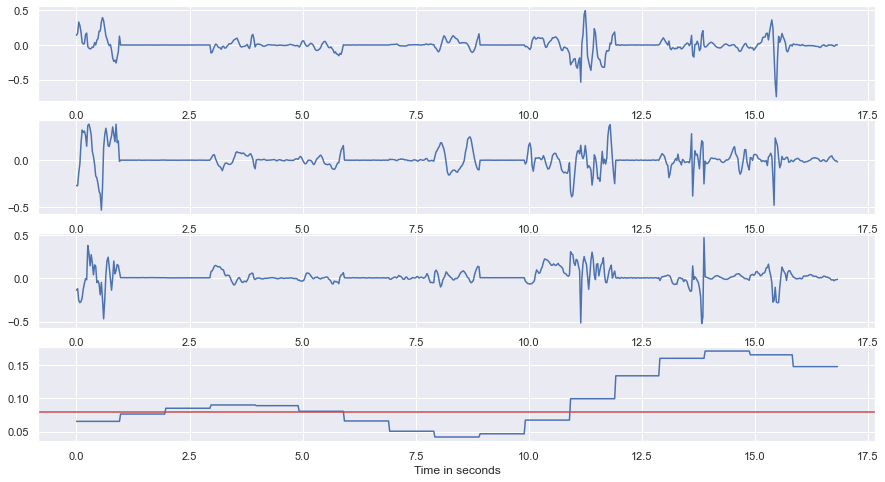

In [35]:
sampling_freq = 40
BK7 = large_df[large_df['pid']=="BK7610"]
zoomed = BK7[:800]
fig, ax = plt.subplots(4,figsize=(15,8))
plt.xlabel("Time in seconds")
time = np.arange(zoomed['x'].size)/sampling_freq
ax[0].plot(time,"x",data=zoomed)
ax[1].plot(time,"y",data=zoomed)
ax[2].plot(time,"z",data=zoomed)
ax[3].plot(time,'TAC_Reading', data=zoomed)
ax[3].axhline(y=0.08, color='r', linestyle='-')
plt.show()

Zooming on 10 seconds

<ipython-input-32-c8f1ed5c67c7>:4: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[0].plot("timestamp","x",data=zoomed)
<ipython-input-32-c8f1ed5c67c7>:5: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[1].plot("timestamp","y",data=zoomed)


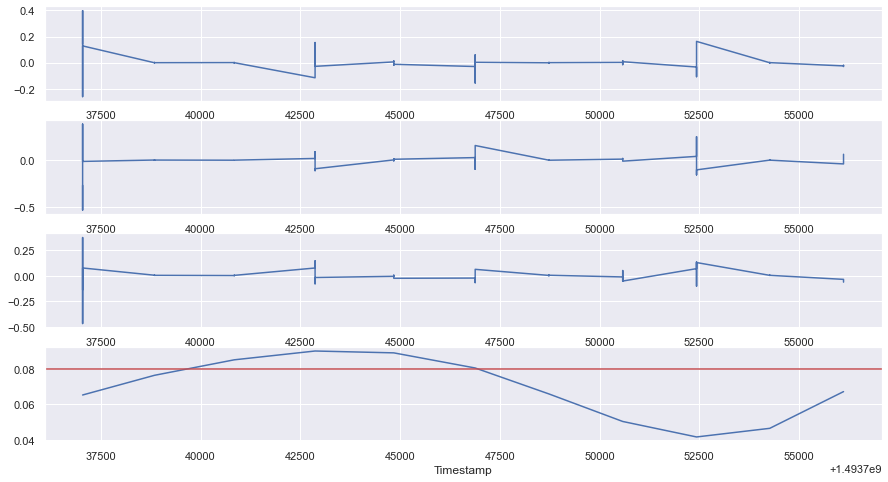

In [32]:
zoomed = BK7[:400]
fig, ax = plt.subplots(4,figsize=(15,8))
plt.xlabel("Timestamp")
ax[0].plot("timestamp","x",data=zoomed)
ax[1].plot("timestamp","y",data=zoomed)
ax[2].plot("timestamp","z",data=zoomed)
ax[3].plot("timestamp",'TAC_Reading', data=zoomed)
ax[3].axhline(y=0.08, color='r', linestyle='-')
plt.show()

<ipython-input-34-e2abf304d28f>:5: RuntimeWarning: Second argument 'x' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[0].plot(time,"x",data=zoomed)
<ipython-input-34-e2abf304d28f>:6: RuntimeWarning: Second argument 'y' is ambiguous: could be a format string but is in 'data'; using as data.  If it was intended as data, set the format string to an empty string to suppress this warning.  If it was intended as a format string, explicitly pass the x-values as well.  Alternatively, rename the entry in 'data'.
  ax[1].plot(time,"y",data=zoomed)


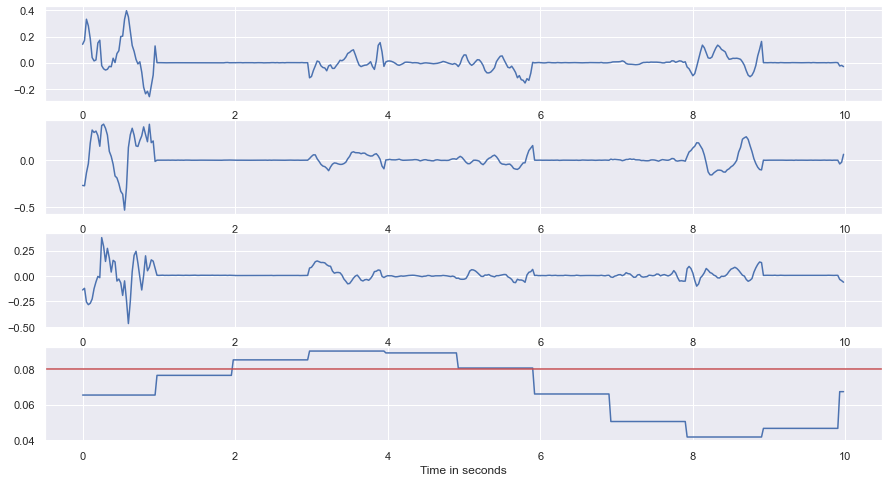

In [34]:
sampling_freq = 40
fig, ax = plt.subplots(4,figsize=(15,8))
plt.xlabel("Time in seconds")
time = np.arange(zoomed['x'].size)/sampling_freq
ax[0].plot(time,"x",data=zoomed)
ax[1].plot(time,"y",data=zoomed)
ax[2].plot(time,"z",data=zoomed)
ax[3].plot(time,'TAC_Reading', data=zoomed)
ax[3].axhline(y=0.08, color='r', linestyle='-')
plt.show()

### Spliting Training & Test according to participants

In [44]:
participants = list(pids)
print(participants)

['BK7610', 'BU4707', 'CC6740', 'DC6359', 'DK3500', 'HV0618', 'JB3156', 'JR8022', 'MC7070', 'MJ8002', 'PC6771', 'SA0297', 'SF3079']


In [39]:
random.seed(100)
def Diff(li1, li2):
  return list(set(li1) - set(li2)) + list(set(li2) - set(li1))

In [42]:
p_tr_index = random.sample(range(1, 13), 9)  # 70%13 = 9.1~9
p_te_index = Diff(list(range(1, 13)),p_tr)  #30%13 = 3.9~4

In [45]:
p_tr_index

[9, 2, 11, 8, 5, 1, 6, 10, 3]

In [46]:
p_te=[]
p_tr = []
for index in p_tr_index:
    p_tr.append(participants[index])
for index in p_te_index:
    p_te.append(participants[index])

In [47]:
p_tr

['MJ8002',
 'CC6740',
 'SA0297',
 'MC7070',
 'HV0618',
 'BU4707',
 'JB3156',
 'PC6771',
 'DC6359']

In [49]:
df_train = pd.DataFrame()
for pid in p_tr:
    tmp = large_df[large_df["pid"]==pid]
    df_train = df_train.append(tmp)

In [50]:
df_train

,timestamp,TAC_Reading,time,pid,x,y,z,label
0,1493745149,0.066343,1493745149021,MJ8002,0.0011,0.0036,-0.0007,0
1,1493745149,0.066343,1493745149046,MJ8002,-0.0008,-0.0009,-0.0002,0
2,1493745149,0.066343,1493745149070,MJ8002,-0.0005,-0.0019,-0.0020,0
3,1493745149,0.066343,1493745149096,MJ8002,0.0010,0.0006,0.0001,0
4,1493745149,0.066343,1493745149121,MJ8002,-0.0006,-0.0035,-0.0009,0
...,...,...,...,...,...,...,...,...
299,1493768340,0.068986,1493768340869,DC6359,-0.0175,-0.0225,0.0733,0
300,1493768340,0.068986,1493768340902,DC6359,-0.0105,-0.0234,-0.0022,0
301,1493768340,0.068986,1493768340924,DC6359,-0.0083,-0.0476,-0.0226,0
302,1493768340,0.068986,1493768340953,DC6359,-0.0480,-0.0286,-0.0621,0


In [51]:
df_test = pd.DataFrame()
for pid in p_te:
    tmp = large_df[large_df["pid"]==pid]
    df_test = df_test.append(tmp)

In [52]:
df_test

,timestamp,TAC_Reading,time,pid,x,y,z,label
0,1493741188,0.041870,1493741188015,CC6740,-4.696118,-16.039703,6.315768,0
1,1493741188,0.041870,1493741188039,CC6740,-8.342324,-6.281204,-9.354126,0
2,1493741188,0.041870,1493741188065,CC6740,-6.992756,-1.318486,-8.665682,0
3,1493741188,0.041870,1493741188089,CC6740,-6.556036,1.632029,-3.295139,0
4,1493741188,0.041870,1493741188217,CC6740,-7.352158,2.141843,2.943863,0
...,...,...,...,...,...,...,...,...
595,1493805699,0.006193,1493805699881,HV0618,-0.001300,0.000000,0.006300,0
596,1493805699,0.006193,1493805699905,HV0618,-0.001000,-0.000100,0.007500,0
597,1493805699,0.006193,1493805699932,HV0618,-0.001100,-0.000600,0.006100,0
598,1493805699,0.006193,1493805699957,HV0618,-0.001300,0.000200,0.007100,0


# Window size = 5 seconds 
5 seconds = 40*5 samples = 200 samples
<br>
step_size = 25 (Since the data is taken at 25 miliseconds)

In [89]:
x_list = []
y_list = []
z_list = []
train_labels = []
window_size = 200
step_size = 25

for i in range(0, df_train.shape[0] - window_size, step_size):
    xs = df_train['x'].values[i: i + 200]
    ys = df_train['y'].values[i: i + 200]
    zs = df_train['z'].values[i: i + 200]
    label = stats.mode(df_train['label'][i: i + 200])[0][0]

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    train_labels.append(label)

In [90]:
len(train_labels)

167

In [68]:
# Statistical Features on raw x, y and z in time domain
X_train = pd.DataFrame()

In [69]:
# mean
X_train['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_train['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_train['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_train['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_train['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_train['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_train['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_train['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_train['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_train['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_train['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_train['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_train['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_train['x_maxmin_diff'] = X_train['x_max'] - X_train['x_min']
X_train['y_maxmin_diff'] = X_train['y_max'] - X_train['y_min']
X_train['z_maxmin_diff'] = X_train['z_max'] - X_train['z_min']

# median
X_train['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_train['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_train['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_train['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_train['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_train['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_train['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_train['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_train['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_train['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_train['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_train['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_train['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_train['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_train['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_train['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_train['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_train['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/200)
X_train['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/200)
X_train['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/200))

# avg resultant
X_train['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_train['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/200)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/200)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/200))

In [70]:
X_train

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_aad,y_aad,z_aad,x_min,...,y_skewness,z_skewness,x_kurtosis,y_kurtosis,z_kurtosis,x_energy,y_energy,z_energy,avg_result_accl,sma
0,0.002932,0.005182,-0.007554,0.065104,0.126922,0.124359,0.022636,0.043546,0.038568,-0.2534,...,3.919881,3.966712,37.279605,25.886262,39.340774,0.004247,0.016136,0.015522,0.066378,0.099261
1,0.003212,0.004801,-0.007730,0.065321,0.126980,0.124396,0.023924,0.043939,0.038795,-0.2534,...,3.923388,3.967629,36.679653,25.880581,39.313587,0.004277,0.016147,0.015534,0.068309,0.102107
2,0.003309,0.005380,-0.007193,0.065356,0.126981,0.124445,0.024295,0.044172,0.039024,-0.2534,...,3.909650,3.950061,36.571254,25.808599,39.177994,0.004282,0.016153,0.015538,0.069333,0.103706
3,0.003392,0.005904,-0.006795,0.065355,0.126973,0.124508,0.024258,0.044203,0.039534,-0.2534,...,3.897985,3.934616,36.554546,25.751100,39.042778,0.004283,0.016157,0.015548,0.070151,0.104847
4,0.003539,0.005872,-0.006940,0.065346,0.126972,0.124514,0.024197,0.044227,0.039627,-0.2534,...,3.898817,3.937507,36.540631,25.755690,39.052347,0.004283,0.016156,0.015552,0.070322,0.104986
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,0.002853,-0.004193,0.001679,0.019229,0.015746,0.022264,0.011025,0.009681,0.015541,-0.0912,...,1.232370,-0.080431,7.787183,8.814599,1.807419,0.000378,0.000266,0.000498,0.024449,0.036951
163,0.001823,-0.003726,0.002132,0.018504,0.014831,0.021644,0.009994,0.008808,0.014406,-0.0912,...,1.562307,-0.175408,8.870764,10.856749,2.300492,0.000346,0.000234,0.000473,0.022616,0.034243
164,0.001074,-0.003373,0.002223,0.018328,0.014430,0.021461,0.009505,0.008177,0.014137,-0.0912,...,1.661110,-0.182787,9.102308,12.189662,2.463667,0.000337,0.000220,0.000466,0.021706,0.032778
165,0.000054,-0.002239,0.001730,0.021332,0.021380,0.021871,0.010420,0.009521,0.015033,-0.1179,...,4.443082,-0.070983,10.511909,29.755069,2.118929,0.000455,0.000462,0.000481,0.023833,0.035932


In [71]:
len(x_list)

167

# Fourier Transform

C:\Users\shubh\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


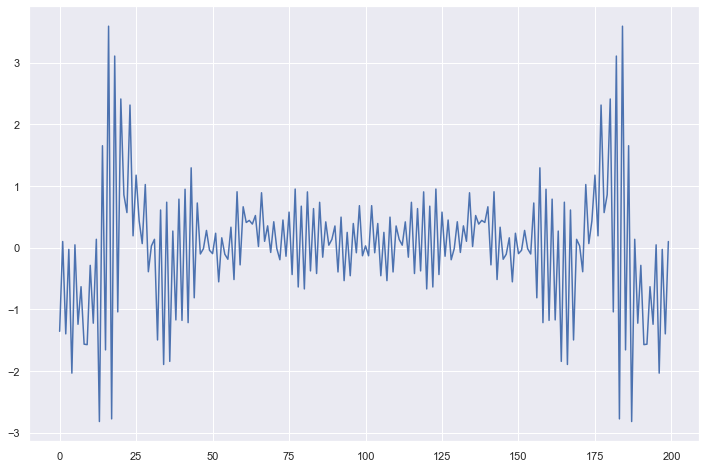

In [72]:
pd.Series(np.fft.fft(pd.Series(x_list)[42])).plot()
plt.show()

##### the signal is symmetric about the center, so we can take only first half of the wave

C:\Users\shubh\anaconda3\lib\site-packages\numpy\core\_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


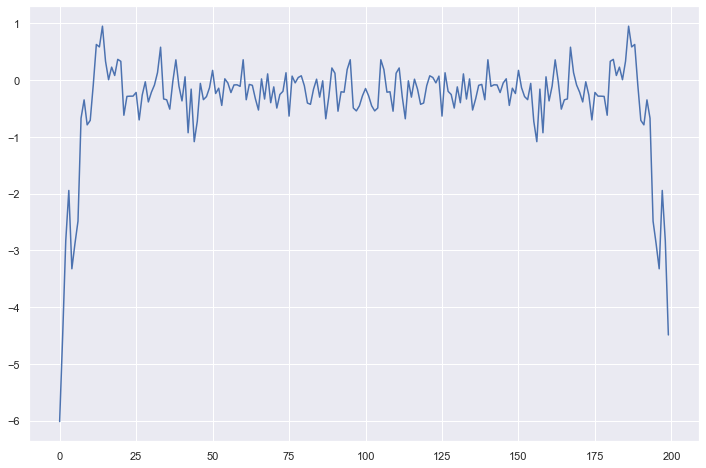

In [73]:
pd.Series(np.fft.fft(pd.Series(x_list)[25])).plot()
plt.show()

the first value is unusually low, its called DC Component in electrical terminology.

In [74]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_train['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_train['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_train['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_train['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_train['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_train['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_train['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_train['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_train['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_train['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_train['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_train['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_train['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_train['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_train['x_maxmin_diff_fft'] = X_train['x_max_fft'] - X_train['x_min_fft']
X_train['y_maxmin_diff_fft'] = X_train['y_max_fft'] - X_train['y_min_fft']
X_train['z_maxmin_diff_fft'] = X_train['z_max_fft'] - X_train['z_min_fft']

# FFT median
X_train['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_train['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_train['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_train['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_train['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_train['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_train['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_train['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_train['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_train['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_train['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_train['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_train['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_train['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_train['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_train['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_train['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/25)
X_train['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/25)
X_train['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/25))

# FFT avg resultant
X_train['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_train['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/25)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/25)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/25))

In [75]:
X_train

,x_mean,y_mean,z_mean,x_std,y_std,z_std,x_aad,y_aad,z_aad,x_min,...,y_skewness_fft,z_skewness_fft,x_kurtosis_fft,y_kurtosis_fft,z_kurtosis_fft,x_energy_fft,y_energy_fft,z_energy_fft,avg_result_accl_fft,sma_fft
0,0.002932,0.005182,-0.007554,0.065104,0.126922,0.124359,0.022636,0.043546,0.038568,-0.2534,...,-0.289455,-0.813607,-0.666255,-1.286619,0.177023,1.278195,8.382839,4.233712,3.540727,5.530565
1,0.003212,0.004801,-0.007730,0.065321,0.126980,0.124396,0.023924,0.043939,0.038795,-0.2534,...,-0.315698,-0.760689,-0.503356,-1.257805,0.017011,1.290940,8.414868,4.269995,3.550255,5.545440
2,0.003309,0.005380,-0.007193,0.065356,0.126981,0.124445,0.024295,0.044172,0.039024,-0.2534,...,-0.310462,-0.753832,-0.481183,-1.250131,0.007016,1.290593,8.419700,4.279704,3.552095,5.549200
3,0.003392,0.005904,-0.006795,0.065355,0.126973,0.124508,0.024258,0.044203,0.039534,-0.2534,...,-0.306709,-0.729045,-0.489752,-1.260570,-0.007423,1.290824,8.416133,4.294935,3.554290,5.552654
4,0.003539,0.005872,-0.006940,0.065346,0.126972,0.124514,0.024197,0.044227,0.039627,-0.2534,...,-0.306561,-0.729065,-0.512966,-1.257977,0.018951,1.289822,8.417390,4.292460,3.553466,5.552001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,0.002853,-0.004193,0.001679,0.019229,0.015746,0.022264,0.011025,0.009681,0.015541,-0.0912,...,0.363886,0.249541,-1.132297,-0.344733,-0.999387,0.244695,0.135794,0.347519,0.810318,1.274200
163,0.001823,-0.003726,0.002132,0.018504,0.014831,0.021644,0.009994,0.008808,0.014406,-0.0912,...,-0.120716,0.258860,-0.480116,-0.255653,-1.213828,0.228257,0.125677,0.342627,0.786685,1.256512
164,0.001074,-0.003373,0.002223,0.018328,0.014430,0.021461,0.009505,0.008177,0.014137,-0.0912,...,-0.409380,0.284698,-0.539328,-0.251277,-1.228592,0.222935,0.122667,0.341739,0.782316,1.243551
165,0.000054,-0.002239,0.001730,0.021332,0.021380,0.021871,0.010420,0.009521,0.015033,-0.1179,...,-0.252059,0.252398,-0.340787,-0.903218,-1.297415,0.266567,0.214160,0.345571,0.867991,1.390685


# Transform the X_test similarly

In [102]:
x_list = []
y_list = []
z_list = []
test_labels = []
window_size = 200
step_size = 25

for i in range(0, df_test.shape[0] - window_size, step_size):
    xs = df_test['x'].values[i: i + 200]
    ys = df_test['y'].values[i: i + 200]
    zs = df_test['z'].values[i: i + 200]
    label = stats.mode(df_test['label'][i: i + 200])[0][0]

    x_list.append(xs)
    y_list.append(ys)
    z_list.append(zs)
    test_labels.append(label)

In [103]:
len(test_labels)

80

In [104]:
# Statistical Features on raw x, y and z in time domain
X_test = pd.DataFrame()

In [105]:
# mean
X_test['x_mean'] = pd.Series(x_list).apply(lambda x: x.mean())
X_test['y_mean'] = pd.Series(y_list).apply(lambda x: x.mean())
X_test['z_mean'] = pd.Series(z_list).apply(lambda x: x.mean())

# std dev
X_test['x_std'] = pd.Series(x_list).apply(lambda x: x.std())
X_test['y_std'] = pd.Series(y_list).apply(lambda x: x.std())
X_test['z_std'] = pd.Series(z_list).apply(lambda x: x.std())

# avg absolute diff
X_test['x_aad'] = pd.Series(x_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad'] = pd.Series(y_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad'] = pd.Series(z_list).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# min
X_test['x_min'] = pd.Series(x_list).apply(lambda x: x.min())
X_test['y_min'] = pd.Series(y_list).apply(lambda x: x.min())
X_test['z_min'] = pd.Series(z_list).apply(lambda x: x.min())

# max
X_test['x_max'] = pd.Series(x_list).apply(lambda x: x.max())
X_test['y_max'] = pd.Series(y_list).apply(lambda x: x.max())
X_test['z_max'] = pd.Series(z_list).apply(lambda x: x.max())

# max-min diff
X_test['x_maxmin_diff'] = X_test['x_max'] - X_test['x_min']
X_test['y_maxmin_diff'] = X_test['y_max'] - X_test['y_min']
X_test['z_maxmin_diff'] = X_test['z_max'] - X_test['z_min']

# median
X_test['x_median'] = pd.Series(x_list).apply(lambda x: np.median(x))
X_test['y_median'] = pd.Series(y_list).apply(lambda x: np.median(x))
X_test['z_median'] = pd.Series(z_list).apply(lambda x: np.median(x))

# median abs dev 
X_test['x_mad'] = pd.Series(x_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad'] = pd.Series(y_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad'] = pd.Series(z_list).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# interquartile range
X_test['x_IQR'] = pd.Series(x_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR'] = pd.Series(y_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR'] = pd.Series(z_list).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# negtive count
X_test['x_neg_count'] = pd.Series(x_list).apply(lambda x: np.sum(x < 0))
X_test['y_neg_count'] = pd.Series(y_list).apply(lambda x: np.sum(x < 0))
X_test['z_neg_count'] = pd.Series(z_list).apply(lambda x: np.sum(x < 0))

# positive count
X_test['x_pos_count'] = pd.Series(x_list).apply(lambda x: np.sum(x > 0))
X_test['y_pos_count'] = pd.Series(y_list).apply(lambda x: np.sum(x > 0))
X_test['z_pos_count'] = pd.Series(z_list).apply(lambda x: np.sum(x > 0))

# values above mean
X_test['x_above_mean'] = pd.Series(x_list).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean'] = pd.Series(y_list).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean'] = pd.Series(z_list).apply(lambda x: np.sum(x > x.mean()))

# number of peaks
X_test['x_peak_count'] = pd.Series(x_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count'] = pd.Series(y_list).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count'] = pd.Series(z_list).apply(lambda x: len(find_peaks(x)[0]))

# skewness
X_test['x_skewness'] = pd.Series(x_list).apply(lambda x: stats.skew(x))
X_test['y_skewness'] = pd.Series(y_list).apply(lambda x: stats.skew(x))
X_test['z_skewness'] = pd.Series(z_list).apply(lambda x: stats.skew(x))

# kurtosis
X_test['x_kurtosis'] = pd.Series(x_list).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis'] = pd.Series(y_list).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis'] = pd.Series(z_list).apply(lambda x: stats.kurtosis(x))

# energy
X_test['x_energy'] = pd.Series(x_list).apply(lambda x: np.sum(x**2)/200)
X_test['y_energy'] = pd.Series(y_list).apply(lambda x: np.sum(x**2)/200)
X_test['z_energy'] = pd.Series(z_list).apply(lambda x: np.sum(x**2/200))

# avg resultant
X_test['avg_result_accl'] = [i.mean() for i in ((pd.Series(x_list)**2 + pd.Series(y_list)**2 + pd.Series(z_list)**2)**0.5)]

# signal magnitude area
X_test['sma'] =    pd.Series(x_list).apply(lambda x: np.sum(abs(x)/200)) + pd.Series(y_list).apply(lambda x: np.sum(abs(x)/200)) \
                  + pd.Series(z_list).apply(lambda x: np.sum(abs(x)/200))

In [106]:
# converting the signals from time domain to frequency domain using FFT
x_list_fft = pd.Series(x_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
y_list_fft = pd.Series(y_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])
z_list_fft = pd.Series(z_list).apply(lambda x: np.abs(np.fft.fft(x))[1:26])

# Statistical Features on raw x, y and z in frequency domain
# FFT mean
X_test['x_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: x.mean())
X_test['y_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: x.mean())
X_test['z_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: x.mean())

# FFT std dev
X_test['x_std_fft'] = pd.Series(x_list_fft).apply(lambda x: x.std())
X_test['y_std_fft'] = pd.Series(y_list_fft).apply(lambda x: x.std())
X_test['z_std_fft'] = pd.Series(z_list_fft).apply(lambda x: x.std())

# FFT avg absolute diff
X_test['x_aad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['y_aad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))
X_test['z_aad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.mean(np.absolute(x - np.mean(x))))

# FFT min
X_test['x_min_fft'] = pd.Series(x_list_fft).apply(lambda x: x.min())
X_test['y_min_fft'] = pd.Series(y_list_fft).apply(lambda x: x.min())
X_test['z_min_fft'] = pd.Series(z_list_fft).apply(lambda x: x.min())

# FFT max
X_test['x_max_fft'] = pd.Series(x_list_fft).apply(lambda x: x.max())
X_test['y_max_fft'] = pd.Series(y_list_fft).apply(lambda x: x.max())
X_test['z_max_fft'] = pd.Series(z_list_fft).apply(lambda x: x.max())

# FFT max-min diff
X_test['x_maxmin_diff_fft'] = X_test['x_max_fft'] - X_test['x_min_fft']
X_test['y_maxmin_diff_fft'] = X_test['y_max_fft'] - X_test['y_min_fft']
X_test['z_maxmin_diff_fft'] = X_test['z_max_fft'] - X_test['z_min_fft']

# FFT median
X_test['x_median_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(x))
X_test['y_median_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(x))
X_test['z_median_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(x))

# FFT median abs dev 
X_test['x_mad_fft'] = pd.Series(x_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['y_mad_fft'] = pd.Series(y_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))
X_test['z_mad_fft'] = pd.Series(z_list_fft).apply(lambda x: np.median(np.absolute(x - np.median(x))))

# FFT Interquartile range
X_test['x_IQR_fft'] = pd.Series(x_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['y_IQR_fft'] = pd.Series(y_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))
X_test['z_IQR_fft'] = pd.Series(z_list_fft).apply(lambda x: np.percentile(x, 75) - np.percentile(x, 25))

# FFT values above mean
X_test['x_above_mean_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['y_above_mean_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x > x.mean()))
X_test['z_above_mean_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x > x.mean()))

# FFT number of peaks
X_test['x_peak_count_fft'] = pd.Series(x_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['y_peak_count_fft'] = pd.Series(y_list_fft).apply(lambda x: len(find_peaks(x)[0]))
X_test['z_peak_count_fft'] = pd.Series(z_list_fft).apply(lambda x: len(find_peaks(x)[0]))

# FFT skewness
X_test['x_skewness_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.skew(x))
X_test['y_skewness_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.skew(x))
X_test['z_skewness_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.skew(x))

# FFT kurtosis
X_test['x_kurtosis_fft'] = pd.Series(x_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['y_kurtosis_fft'] = pd.Series(y_list_fft).apply(lambda x: stats.kurtosis(x))
X_test['z_kurtosis_fft'] = pd.Series(z_list_fft).apply(lambda x: stats.kurtosis(x))

# FFT energy
X_test['x_energy_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(x**2)/25)
X_test['y_energy_fft'] = pd.Series(y_list_fft).apply(lambda x: np.sum(x**2)/25)
X_test['z_energy_fft'] = pd.Series(z_list_fft).apply(lambda x: np.sum(x**2/25))

# FFT avg resultant
X_test['avg_result_accl_fft'] = [i.mean() for i in ((pd.Series(x_list_fft)**2 + pd.Series(y_list_fft)**2 + pd.Series(z_list_fft)**2)**0.5)]

# FFT Signal magnitude area
X_test['sma_fft'] = pd.Series(x_list_fft).apply(lambda x: np.sum(abs(x)/25)) + pd.Series(y_list_fft).apply(lambda x: np.sum(abs(x)/25)) \
                     + pd.Series(z_list_fft).apply(lambda x: np.sum(abs(x)/25))

In [107]:
X_test.shape

(80, 94)

In [108]:
X_train.shape

(167, 94)

# Logistic Model


In [109]:
y_train = np.array(train_labels)
y_test = np.array(test_labels)

In [110]:
len(y_test)

80

In [112]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# standardization
scaler = StandardScaler()
scaler.fit(X_train)
X_train_data_lr = scaler.transform(X_train)
X_test_data_lr = scaler.transform(X_test)
# logistic regression model
lr = LogisticRegression(random_state = 21)
lr.fit(X_train_data_lr, y_train)
y_pred = lr.predict(X_test_data_lr)
accuracy = accuracy_score(y_test,y_pred)
print("Accuracy:", accuracy)
print("\n -------------Classification Report-------------\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.9875

 -------------Classification Report-------------

              precision    recall  f1-score   support

           0       1.00      0.99      0.99        78
           1       0.67      1.00      0.80         2

    accuracy                           0.99        80
   macro avg       0.83      0.99      0.90        80
weighted avg       0.99      0.99      0.99        80

